# PiB-PET Processing for Preclinical Alzheimer's Disease Consortium

The processing steps can be summarized as follows:
1. Time frame alignment
2. MRI-PET coregistration (MRIs have already been processed and anatomical regions have been defined)
3. Extraction of early amyloid (EA), SUVR, BP, DVR, R<sub>1</sub> images
4. ROI summary calculation
5. Spatial normalization of all output images to MNI space

Steps 3-5 will be performed with and without partial volume correction.

In [14]:
# Import packages
import os, sys, logging
import pandas as pd
import numpy as np
import scipy as sp
import math

# for plotting
from nilearn.plotting import show, plot_stat_map, plot_anat, plot_img, plot_glass_brain, cm
from nilearn.image import iter_img
from nilearn.masking import apply_mask
from dipy.viz import regtools
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.pylabtools import figsize
%matplotlib inline

# nipype
import nipype.interfaces.io as nio
from nipype.interfaces import spm, fsl, petpvc
from nipype.pipeline.engine import Workflow, Node, JoinNode
from nipype.interfaces.utility import Function, IdentityInterface, Merge
from nipype.pipeline.plugins.callback_log import log_nodes_cb
from nipype_funcs import * # nipype_funcs.py must be in current working directory (or otherwise discoverable by python)
from nipype import config, logging
config.enable_debug_mode()
logging.update_logging(config)

In [15]:
# Prototype script for QC reports
prototypescript = os.path.join(os.getcwd(), 'pib_qc.py')

# Use standalone SPM rather than through MATLAB
standalone_spm_dir = os.path.join(os.environ['SOFTWARE'], 'standalone_spm')

# directory to store the workflow results
output_dir = os.path.join(os.getcwd(), os.pardir, 'results', 'pib_processing_example')

# prefix for the data collection site
sitePrefix = 'BLSA'

# spreadsheet with the following columns: blsaid, blsavi, PIBpath, PIBtimingpath, musemripath, muselabelpath
organization_spreadsheet = os.path.join(os.getcwd(), os.pardir, 'inputs', 'PETstatus_08Feb2017.xlsx')

# columns required in the spreadsheet
required_cols = ['blsaid','blsavi','PIBpath','PIBtimingpath','musemripath','muselabelpath']

# values to be treated as missing in the spreadsheet - do not include NA as a null value as it is a valid EMSID
NAN_VALUES = ['-1.#IND', '1.#QNAN', '1.#IND', '-1.#QNAN', '#N/A','N/A', '#NA', 'NULL', 'NaN', '-NaN', 'nan', '-nan','']

In [16]:
# PiB processing parameters
# 2-min mean, used for time frame realignment
startTime_2min = 0.75
endTime_2min = 2

# 20-min mean, used for MRI coregistration
startTime_20min = 0.75
endTime_20min = 20

# 5-min mean, used for early amyloid image computation
startTime_EA = 0.75
endTime_EA = 5

# 50 to 70-min mean, used for SUVR computation
startTime_50to70min = 50
endTime_50to70min = 70

# Used for DVR computation
endTime_DVR = 70

# PVC smoothing parameters: PET scanner PSF FWHM (in mm)
pvc_fwhm_x = 6.7
pvc_fwhm_y = 6.7
pvc_fwhm_z = 6.7

# Smoothing parameter (in mm) used for SUVR and SRTM
smooth_fwhm = 4.25

# For trimmed mean of ROI signal, proportion to cut (exclude) from each tail of the distribution
proportiontocut = 0.05

In [17]:
# Set up standalone SPM
matlab_cmd = os.path.join(standalone_spm_dir,'spm12','run_spm12.sh') + ' ' + \
             os.path.join(standalone_spm_dir,'MCR','v713' + ' script')

spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)
spm.SPMCommand().version # testing

'12.6914'

In [18]:
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [19]:
# LOGGING


In [20]:
# Read in the organization spreadsheet and extract information
data_table = pd.read_excel(organization_spreadsheet, keep_default_na=False, na_values=NAN_VALUES)

for col in required_cols:
    if not col in data_table.columns:
        sys.exit('Required column ' + col + ' is not present in the data organization spreadsheet ' + \
                 organization_spreadsheet + '!')

# Find all visits with PiB-PET (excluding incomplete/interrupted PiB scans) and MUSE labels
data_table = data_table[required_cols].dropna(axis=0, how='any')

#mri_list = pib_data['mripath'].values.tolist()
musemri_list = data_table['musemripath'].values.tolist()
muselabel_list = data_table['muselabelpath'].values.tolist()
pib_list = data_table['PIBpath'].values.tolist()
pibtiming_list = data_table['PIBtimingpath'].values.tolist()

subjID = data_table['blsaid'].values.tolist()
visNo = data_table['blsavi'].values.tolist()
blsavi_integer = [ math.floor(x) for x in visNo ]
blsavi_decimal = [ str(x).split('.')[1] for x in visNo ]

idvi_list = ["%04d_%02d-%s" % idvi for idvi in zip(subjID,blsavi_integer,blsavi_decimal)]

# Form dictionaries, with IDs as keys and paths to images as values
pib_dict = dict(zip(idvi_list, pib_list))
pibtiming_dict = dict(zip(idvi_list, pibtiming_list))
musemri_dict = dict(zip(idvi_list, musemri_list))
muselabel_dict = dict(zip(idvi_list, muselabel_list))

## INPUTS

We set up the nipype Nodes that will act as the inputs to our Workflows. The `infosource` Node allows for iterating over scan IDs. The remaining input Nodes allow for the retrieval of the PiB, processed MRI, and label images given the scan IDs (`getpib`, `getmusemri`, `getmuselabel`, respectively), as well as the retrieval of the text files detailing the frame timing information (`getpibtiming`).

In [21]:
# placeholder Node to enable iteration over scans
infosource = Node(interface=IdentityInterface(fields=['idvi']),
                  name="infosource")
infosource.iterables = ('idvi', idvi_list)

# get full path to PiB scan corresponding to idvi from spreadsheet
getpib = Node(Function(input_names=['key','dict'],
                       output_names=['pib'],
                       function=get_value),
              name='getpib')
getpib.inputs.dict = pib_dict

# get full path to the txt file listing the duration of each PiB time frame
#  number of rows must be the same as the number of PiB time frames, with each row listing the time in minutes
getpibtiming = Node(Function(input_names=['key','dict'],
                             output_names=['pibtiming'],
                             function=get_value),
                    name='getpibtiming')
getpibtiming.inputs.dict = pibtiming_dict

# get full path to MRI corresponding to idvi from spreadsheet, in same space as MUSE labels
getmusemri = Node(Function(input_names=['key','dict'],
                           output_names=['musemri'],
                           function=get_value),
                  name='getmusemri')
getmusemri.inputs.dict = musemri_dict

# get full path to MUSE label image corresponding to idvi from spreadsheet, in same space as MRI
getmuselabel = Node(Function(input_names=['key','dict'],
                             output_names=['muselabel'],
                             function=get_value),
                    name='getmuselabel')
getmuselabel.inputs.dict = muselabel_dict

Normally, we wouldn't run the following line, but for demonstration purposes here, we are going to run the Workflows on a single scan. Thus, we include only the first scan ID in our iterable list.

In [22]:
infosource = Node(interface=IdentityInterface(fields=['idvi']),
                  name="infosource")
infosource.iterables = ('idvi', idvi_list[:1])

idvi_example = idvi_list[0]

## REALIGN

The goal of the realign workflow is to compute a spatially-aligned dynamic PiB-PET image by removing subject motion.

* `reorient`: We start by reorienting the PET image to match the orientation of MNI152 templates. This is not spatial normalization - no registration is performed. We simply apply 90, 180, or 270 degree rotations as needed about the $x,y,z$ axes to match the MNI152 orientation.

We will align each time frame to the average of the first 2 minutes of acquisition. We use the first 2 minutes because they do not reflect amyloid binding but instead reflect blood flow, which has better anatomical definition that aids in the registration. We assume that the time frames in the first 2 minutes are in alignment, so we will not apply any spatial transformations to these frames.

* `split_time_2mins`: Split the dynamic scan into $< 2$ min and $\geq 2$ min.
* `dynamic_mean_2min`: Compute the average of the time frames in the $< 2$ mins.

We are going to use SPM's Realign function to perform time frame alignment, using the "align to first time frame" option. Thus, we create an artificial image where the first frame is the 2-min average, and the following frames are the dynamic scan frames $\geq 2$ min.

* `merge_lists`: Concatenates the full paths to the 2-min average image and time frames $\geq 2$ min, separated by a space.
* `merge_time`: Takes the concatenated string and performs the image concatenation.
* `pad`: In order to minimize interpolation artifacts at image edges, we pad each time frame on each of the 6 sides with the nearest slice prior to time frame alignment.
* `realign`: This is the SPM function to do the actual work.
* `unpad`: We reverse the padding to return to original image dimensions.
* `drop_first_timeframe`: We had artifically put this first time frame (which is the 2-min average) to get SPM's realign function to work. We remove it after realignment.
* `nan_to_0`: In case SPM transformations introduced any nan's (due to voxels coming into view from outside of the original image), we set these to 0 to avoid problems down the line.
* `merge_lists2` and `merge_time2`: We need to add back the first 2-minutes of time frames to the beginning of the realigned image.

_Note:_ For acquisitions that do not include time frames $< 2$ minutes post-injection, we align to the mean time frame of the entire acquisition. This is achieved directly by setting the proper SPM Realign options. SPM uses a two-pass procedure when aligning to the mean image.

In [23]:
# Reorient
reorient = Node(interface=fsl.Reorient2Std(output_type='NIFTI'), name="reorient")

# Split the dynamic scan at the 2 min mark
split_time_2mins = Node(interface=SplitTimeSeries(splitTime=endTime_2min), name="split_time_2mins")

# Compute 0.75-2 min average that will be used for time frame alignment
dynamic_mean_2min = Node(interface=DynamicMean(startTime=startTime_2min, endTime=endTime_2min), name="dynamic_mean_2min")

merge_lists = Node(interface=Merge(2), name="merge_lists")
merge_time = Node(interface=fsl.Merge(dimension='t', output_type='NIFTI_PAIR'), name="merge_time")
# output type is NIFTI_PAIR because that is what SPM (used for realign) likes

pad = Node(interface=Pad4DImage(padsize=1),name="pad")
unpad = Node(interface=Unpad4DImage(padsize=1),name="unpad")

# Realign time frames
realign = Node(interface=spm.Realign(), name="realign")
# === Estimate options ===
realign.inputs.quality = 1
realign.inputs.separation = 4 # Separation in mm b/w points sampled in reference
                              # image. Smaller more accurate but slower
realign.inputs.fwhm = 7 # FWHM in mm of the Gaussian smoothing kernel applied
                        # to the images before estimating realignment parameters
realign.inputs.register_to_mean = False # align to the first time frame,
                                        # which we've hacked to be the 2 min avg
realign.inputs.interp = 2 # degree of interpolation. Higher is better but slower
realign.inputs.wrap = [0, 0, 0] # no wrap around in PET
# === Reslice options ===
realign.inputs.write_which = [1, 0] # do not to reslice the first timeframe
realign.inputs.write_interp = 4
realign.inputs.write_mask = True
realign.inputs.write_wrap = [0, 0, 0]
realign.inputs.out_prefix = 'r'
realign.inputs.jobtype = 'estwrite'
realign.use_mcr = True # run using standalone SPM (without MATLAB)

# After alignment, drop first time frame, which is the 2 min average
drop_first_timeframe = Node(interface=fsl.ExtractROI(t_min=1,t_size=-1), name="drop_first_timeframe")

# Replace nan values after realignment with 0
nan_to_0 = Node(interface=fsl.ImageMaths(op_string=' -nan', suffix='_nanto0'), name='nan_to_0')

merge_lists2 = Node(interface=Merge(2), name="merge_lists2")
merge_time2 = Node(interface=fsl.Merge(dimension='t'), name="merge_time2")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','realign_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('_roi',''),
                                 ('_merged',''),
                                 ('mean','avg2min'),
                                 ('_reoriented','')]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

realign_workflow = Workflow(name="realign_workflow")
realign_workflow.base_dir = os.path.join(output_dir,'realign_workingdir')
realign_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'realign_crashdumps')}}
realign_workflow.connect([(getpib, reorient, [('pib','in_file')]),
                          # get time frames beyond first two minutes (we assume first 2 mins are free of motion)
                          (reorient, split_time_2mins, [('out_file','timeSeriesImgFile')]),
                          (getpibtiming, split_time_2mins, [('pibtiming','frameTimingCsvFile')]),

                          # compute 0.75-2 min average (initial frames are excluded due to insufficient SNR)
                          (reorient, dynamic_mean_2min, [('out_file','timeSeriesImgFile')]),
                          (getpibtiming, dynamic_mean_2min, [('pibtiming','frameTimingCsvFile')]),

                          # perform time alignment to the average of first 2 mins
                          (dynamic_mean_2min, merge_lists, [('meanImgFile','in1')]),
                          (split_time_2mins, merge_lists, [('secondImgFile','in2')]),
                          (merge_lists, merge_time, [('out','in_files')]),

                          (merge_time, pad, [('merged_file','timeSeriesImgFile')]),
                          (pad, realign, [('paddedImgFile','in_files')]),
                          (realign, unpad, [('realigned_files','timeSeriesImgFile')]),
                          (unpad, drop_first_timeframe, [('unpaddedImgFile','in_file')]),

                          (drop_first_timeframe, nan_to_0, [('roi_file','in_file')]),

                          # put together the first 2 minutes with the rest of the time frames, which have been motion-corrected
                          (split_time_2mins, merge_lists2, [('firstImgFile','in1')]),
                          (nan_to_0, merge_lists2, [('out_file','in2')]),
                          (merge_lists2, merge_time2, [('out','in_files')]),

                          # save outputs
                          (dynamic_mean_2min, datasink, [('meanImgFile','avg2min')]), # 0.75-2min average (3D image) used in time frame alignment
                          (merge_time2, datasink, [('merged_file','realigned')]), # realigned time series (4D image)
                          (realign, datasink, [('realignment_parameters','realigned.@par')]), # realignment parameters
                         ])

We connect the inputs to the realignment workflow and run:

In [37]:
pib_workflow = Workflow(name="pib_workflow")
pib_workflow.base_dir = output_dir
pib_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'pib_crashdumps')}}
pib_workflow.connect([# PET time frame realignment
                      (infosource, realign_workflow, [('idvi','getpib.key'),
                                                      ('idvi','getpibtiming.key')])
                    ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': 24, 'status_callback': log_nodes_cb})

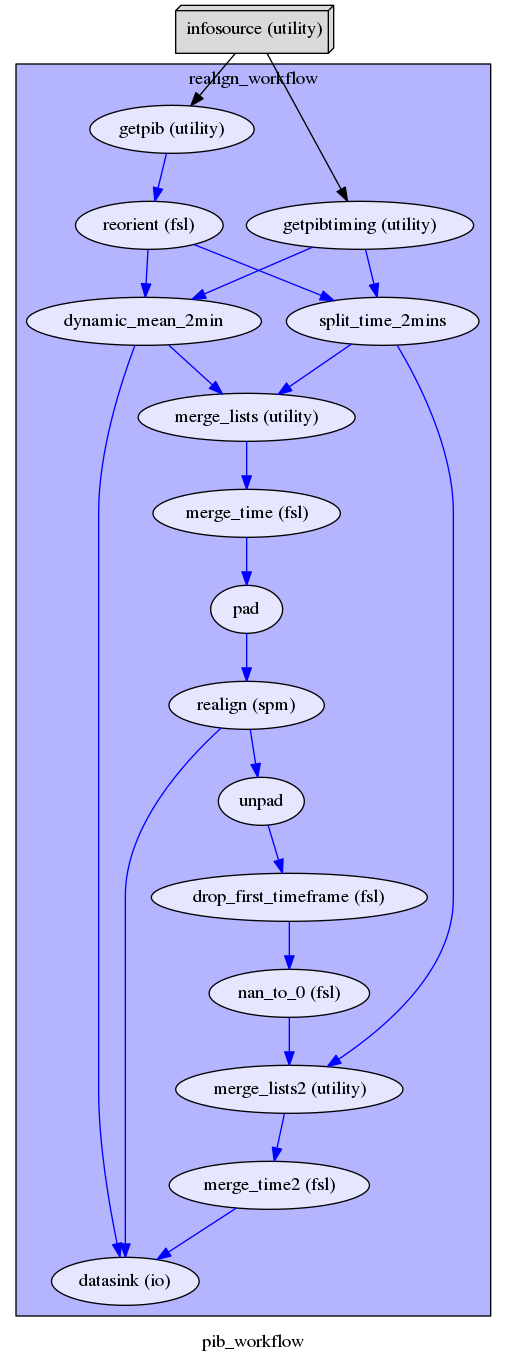

In [38]:
realign_workflow.write_graph('realign.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'pib_workflow','realign.dot.png'))

Using the `datasink` in the realignment workflow, we saved copies of the main outputs of interest into a subdirectory named `output/realign_wf`.

In [46]:
frameTimingCsvFile = pibtiming_dict[idvi_example]
splitTime = endTime_2min

frameTiming = pd.read_csv(frameTimingCsvFile)
# check that frameTiming has columns named frameStart and frameEnd
for col in ['frameStart','frameEnd']:
    if not col in frameTiming.columns:
        sys.exit('Required column '+col+' is not present in the frame timing spreadsheet '+frameTimingCsvFile+'!')
frameStart = frameTiming['frameStart']
frameEnd = frameTiming['frameEnd']
# sanity checks on frameTiming spreadsheet entries
assert(len(frameTiming)>1)
assert(all(frameStart<frameEnd))
assert(all(frameStart[1:]==frameEnd[:len(frameEnd)-1]))

frameStart = frameStart.as_matrix() #tolist()
frameEnd = frameEnd.as_matrix() #tolist()

splitIndex = next((i for i,t in enumerate(frameStart) if t>=splitTime), len(frameTiming))

# Compute the time mid-way for each time frame
t = (frameStart + frameEnd)/2

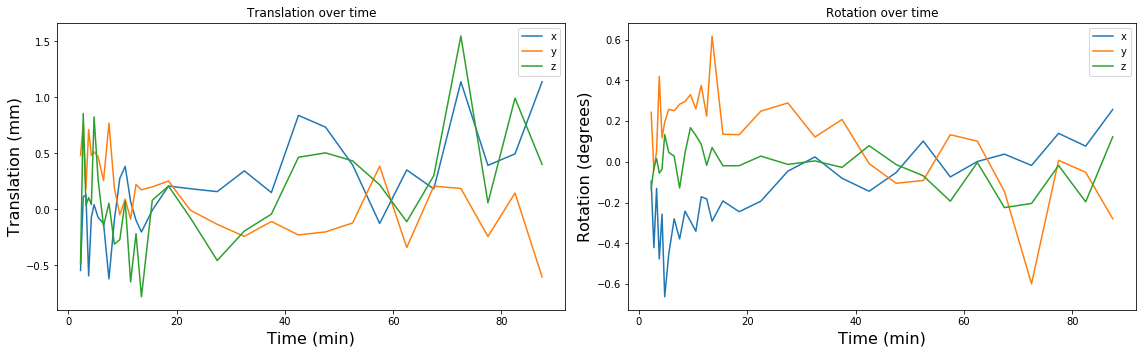

In [52]:
from glob import glob
realignParamsFile = glob(os.path.join(output_dir,'pib_workflow','realign_workflow','_idvi_'+idvi_example,'realign',
                                      'rp_*.txt'))[0]

# Time realignment parameters
rp = pd.read_csv(realignParamsFile,delim_whitespace=True, header=None).as_matrix()
translation = rp[1:,:3]
rotation = rp[1:,3:] * 180 / math.pi

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(t[splitIndex:],translation[:,0],label='x')
plt.plot(t[splitIndex:],translation[:,1],label='y')
plt.plot(t[splitIndex:],translation[:,2],label='z')
plt.legend(loc=0)
plt.title('Translation over time')
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Translation (mm)', fontsize=16)

plt.subplot(122)
plt.plot(t[splitIndex:],rotation[:,0],label='x')
plt.plot(t[splitIndex:],rotation[:,1],label='y')
plt.plot(t[splitIndex:],rotation[:,2],label='z')
plt.legend(loc=0)
plt.title('Rotation over time')
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Rotation (degrees)', fontsize=16)

plt.tight_layout()